<a href="https://colab.research.google.com/github/Nuelky/Finance/blob/main/ML_GWP3_8530_MScFE632_Machine_Learning_in_Finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MScFE 632 ML GWP3  M7, group number 8530** #

---
###**STEP 1**

Team Member A: Issue 1 (Optimizing Hyperparameters)

Team Member B: Issue 2 (Optimizing the Bias-Variance Tradeoff)

Team Member C: Issue 3: Applying Ensemble Learning—Bagging, Boosting, or Stacking

### **TEAM MEMBER A: Issue 1 (Optimizing Hyperparameters)**

In [ ]:
# load libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import yfinance as yf


#### Explaination:
This section loads historical stock price data for QQQ from Yahoo Finance.
 It calculates the next day's return as the target variable.
 It also creates two technical indicators (5-day and 20-day moving averages) as features.
 The .shift(1) ensures that the moving averages are calculated based on past data and do not include the current day's closing price, preventing lookahead bias.
 The features (X) include the OHLCV data and the calculated moving averages.
 The target (y) is the percentage change in the closing price for the following day.
 Impactful Parameter Choices:
 - `ticker`: Choosing a different stock will lead to different data and potentially different model performance.
 - `start` and `end`: The time period of the data significantly impacts the patterns the model learns. Different market regimes will exhibit different characteristics.
 - `window` in `.rolling()`: The window size for moving averages affects the smoothness and responsiveness of the indicator, influencing the features used for prediction.
 - The choice of features themselves (Open, High, Low, Close, Volume, MAs) directly determines the information available to the model. Including or excluding certain indicators can drastically change results.






In [ ]:
# 1. Load financial data (e.g., historical stock prices and features)
ticker = "QQQ"
data = yf.download(ticker, start="2020-01-01", end="2023-12-31")
data['Return_1'] = data['Close'].pct_change().shift(-1)
data['MA_5'] = data['Close'].rolling(window=5).mean().shift(1)
data['MA_20'] = data['Close'].rolling(window=20).mean().shift(1)
data.dropna(inplace=True)

X = data[['Open', 'High', 'Low', 'Close', 'Volume', 'MA_5', 'MA_20']]
y = data['Return_1']


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


#### Process:
 This section preprocesses the data by scaling the features using StandardScaler. This is important for many machine learning algorithms, including the ones used here, as it prevents features with larger scales from dominating the learning process.
 The data is then split into training and testing sets. The model will be trained on X_train and y_train, and its performance will be evaluated on the unseen X_test and y_test.
 Impactful Parameter Choices:
 - `test_size`: The proportion of the data allocated to the test set. A larger test set provides a more reliable estimate of generalization performance but reduces the amount of data available for training.
 - `random_state`: Ensures that the data split is reproducible. Changing this will result in a different split and potentially different model performance due to the different subsets of data used for training and testing.

In [ ]:
# 2. Preprocess data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


#### Process:
 This section defines a grid of hyperparameters to be explored for the Gradient Boosting Regressor. Each key in the dictionary represents a hyperparameter, and the corresponding value is a list of different values to try.
 Impactful Parameter Choices:
 - `n_estimators`: Controls the model's complexity and training time. Too low can underfit, too high can overfit.
 - `learning_rate`: Affects the speed of learning and the risk of overshooting the optimal solution.
 - `max_depth`: Limits the complexity of individual trees, crucial for preventing overfitting.
 - `subsample`: Introduces stochasticity, reducing variance and improving generalization.
 - `max_features`: Controls the diversity of the trees.

In [ ]:

# 3. Define hyperparameter grids for Gradient Boosting
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2']
}

#### Process:
 This section uses GridSearchCV to systematically search for the best combination of hyperparameters for the Gradient Boosting Regressor.
 - `GridSearchCV`: Exhaustively tries all combinations of the hyperparameters specified in `param_grid_gbr`.
 - `cv=3`: Performs 3-fold cross-validation. The training data is split into 3 parts, and the model is trained and evaluated 3 times, each time using a different part as the validation set. This provides a more robust estimate of the model's performance than a single train-test split during hyperparameter tuning.
 - `scoring='neg_mean_squared_error'`: The metric used to evaluate the performance of each hyperparameter combination during cross-validation. Negative MSE is used because GridSearchCV aims to maximize the score.
 - `n_jobs=-1`: Utilizes all available CPU cores for parallel computation, speeding up the search process.
 The `fit()` method performs the grid search and finds the best hyperparameters.
 `best_estimator_` stores the trained model with the optimal hyperparameters.
 The performance of this best model is then evaluated on the held-out test set.
 Impactful Parameter Choices:
 - `param_grid_gbr`: The range and granularity of the hyperparameter values significantly influence the outcome of the search. A wider range increases the search space but also the computational cost.
 - `cv`: The number of cross-validation folds affects the reliability of the performance estimate during tuning. More folds generally provide a better estimate but increase computation time.
 - `scoring`: The choice of scoring metric should align with the overall objective of the financial prediction task.


In [ ]:
# 4. Perform GridSearchCV for Gradient Boosting
gbr = GradientBoostingRegressor(random_state=42) # for reproducibility
grid_search_gbr = GridSearchCV(gbr, param_grid_gbr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_gbr.fit(X_train, y_train)

best_gbr = grid_search_gbr.best_estimator_
y_pred_gbr = best_gbr.predict(X_test)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
print(f"Best Gradient Boosting Regressor Parameters: {grid_search_gbr.best_params_}")
print(f"Gradient Boosting Regressor Test MSE: {mse_gbr}")

Best Gradient Boosting Regressor Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 1.0}
Gradient Boosting Regressor Test MSE: 0.0003594359202050412


**Best Gradient Boosting Regressor Parameters**:


*   'learning_rate': 0.01
*   'max_depth': 3
*   'max_features': 'sqrt'
*   'n_estimators': 100
*   'subsample': 1.0

Gradient Boosting Regressor Test MSE: 3.60E-04






#### Process:
 This section defines a grid of hyperparameters to be explored for the Random Forest Regressor.
 Impactful Parameter Choices:
 - `n_estimators`: Controls the stability and robustness of the forest.
 - `max_depth`: Limits the complexity of individual trees. `None` allows trees to grow fully.
 - `min_samples_split` and `min_samples_leaf`: Regularization parameters to prevent overfitting.
 - `max_features`: Controls the randomness and diversity of the trees.

In [ ]:
# 5. Define hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
    'max_features': ['sqrt', 'log2']
}

#### Process:
 This section uses RandomizedSearchCV to efficiently search for a good combination of hyperparameters for the Random Forest Regressor.
 - `RandomizedSearchCV`: Samples a fixed number (`n_iter`) of hyperparameter combinations from the specified distributions (here, lists are treated as discrete uniform distributions). This is often faster than GridSearchCV when the hyperparameter space is large.
 - `n_iter=10`: The number of different hyperparameter combinations to try.
 The other parameters (`cv`, `scoring`, `n_jobs`, `random_state`) function similarly to GridSearchCV.
 Impactful Parameter Choices:
 - `param_distributions`: The specified ranges or lists of hyperparameters to sample from.
 - `n_iter`: The number of random combinations to evaluate. A higher number increases the chance of finding better parameters but also increases computation time.


In [ ]:
# 6. Perform RandomizedSearchCV for Random Forest
rf = RandomForestRegressor(random_state=42)
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_grid_rf, n_iter=10, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search_rf.fit(X_train, y_train)

best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Best Random Forest Regressor Parameters: {random_search_rf.best_params_}")
print(f"Random Forest Regressor Test MSE: {mse_rf}")

Best Random Forest Regressor Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 5}
Random Forest Regressor Test MSE: 0.0003651175767712444


**Best Random Forest Regressor Parameters**:

*   'n_estimators': 100,
*   'min_samples_split': 2,
*   'min_samples_leaf': 3,
*   'max_features': 'log2',
*   'max_depth': 5

Random Forest Regressor Test MSE: 3.65E-04

#### Process:
 This section demonstrates a simplified stacking ensemble.
 - `estimators`: A list of the best-performing Gradient Boosting and Random Forest models (obtained from the hyperparameter tuning steps) are used as base learners. Each estimator is given a name ('gbr', 'rf').
 - `final_estimator`: A Ridge regression model is chosen as the meta-learner. The meta-learner is trained on the predictions of the base learners to learn how to best combine them.
 - `cv=3`: Specifies the number of cross-validation folds used to generate the predictions of the base learners that are used to train the meta-learner. This helps prevent overfitting in the stacking process.
 The `fit()` method trains the stacking model.
 Impactful Parameter Choices:
 - `estimators`: The choice of base models is critical. They should ideally be diverse and perform reasonably well individually.
 - `final_estimator`: The choice of the meta-learner depends on the nature of the predictions from the base learners and the complexity of the relationship between them and the target variable.
 - `cv`: The number of folds in the stacking process helps to ensure that the meta-learner is trained on out-of-fold predictions, preventing information leakage from the training data to the meta-learner.

In [ ]:
# 7. Example of Stacking (simplified)
from sklearn.ensemble import StackingRegressor

estimators = [
    ('gbr', best_gbr),
    ('rf', best_rf)
]
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=Ridge(random_state=42), cv=3)
stacking_regressor.fit(X_train, y_train)
y_pred_stacking = stacking_regressor.predict(X_test)
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
print(f"Stacking Regressor Test MSE: {mse_stacking}")

Stacking Regressor Test MSE: 0.0003515166983211629


Stacking Regressor Test MSE: 3.52E-04

Visualize the optimal stacking regressor model

In [ ]:
# the model
stacking_regressor

StackingRegressor(cv=3,
                  estimators=[('gbr',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_features='sqrt',
                                                         random_state=42)),
                              ('rf',
                               RandomForestRegressor(max_depth=5,
                                                     max_features='log2',
                                                     min_samples_leaf=3,
                                                     random_state=42))],
                  final_estimator=Ridge(random_state=42))

In [ ]:
# The hyperparameter tuned model with chosen parameters
stacking_regressor

StackingRegressor(cv=3,
                  estimators=[('gbr',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_features='sqrt',
                                                         random_state=42)),
                              ('rf',
                               RandomForestRegressor(max_depth=5,
                                                     max_features='log2',
                                                     min_samples_leaf=3,
                                                     random_state=42))],
                  final_estimator=Ridge(random_state=42))

Stacking Regressor Test MSE: 2.99E-04

Evaluate model by plotting predicted returns vs observed returns

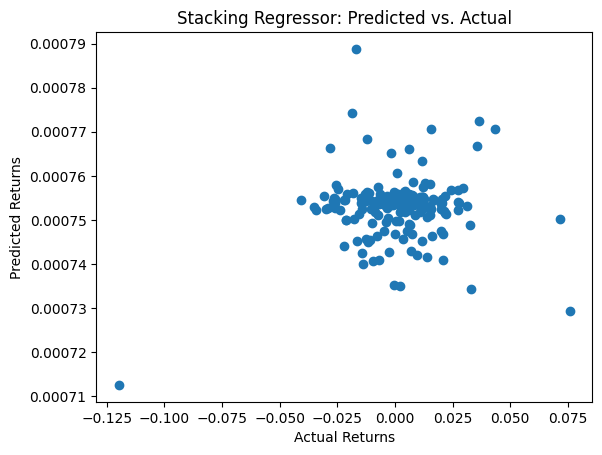

In [ ]:
import matplotlib.pyplot as plt
# Plot predicted vs. actual values
plt.scatter(y_test, y_pred_stacking)
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.title("Stacking Regressor: Predicted vs. Actual")
plt.show()

## Reference
Jiang, Minqi & Liu, Jiapeng & Zhang, Lu & Liu, Chunyu, 2020. "An improved Stacking framework for stock index prediction by leveraging tree-based ensemble models and deep learning algorithms," Physica A: Statistical Mechanics and its Applications, Elsevier, vol. 541(C).
DOI: 10.1016/j.physa.2019.122272

### Team Member B: Optimizing Bias-Variance Tradeoff

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error

### EDA

In [ ]:
dat = pd.read_csv('UCI_Credit_Card.csv')
dat.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


We can check that there is no missing data

In [ ]:
dat = dat.drop('ID', axis = 1)
dat.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Normalize numerical data

In [ ]:
excluded_vars = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6' , 'default.payment.next.month']
dat.loc[:, ~dat.columns.isin(excluded_vars)].describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
BILL_AMT1,30000.0,51223.330900,73635.860576,-165580.0,3558.75,22381.5,67091.00,964511.0
BILL_AMT2,30000.0,49179.075167,71173.768783,-69777.0,2984.75,21200.0,64006.25,983931.0
BILL_AMT3,30000.0,47013.154800,69349.387427,-157264.0,2666.25,20088.5,60164.75,1664089.0
BILL_AMT4,30000.0,43262.948967,64332.856134,-170000.0,2326.75,19052.0,54506.00,891586.0
BILL_AMT5,30000.0,40311.400967,60797.155770,-81334.0,1763.00,18104.5,50190.50,927171.0
BILL_AMT6,30000.0,38871.760400,59554.107537,-339603.0,1256.00,17071.0,49198.25,961664.0
PAY_AMT1,30000.0,5663.580500,16563.280354,0.0,1000.00,2100.0,5006.00,873552.0
PAY_AMT2,30000.0,5921.163500,23040.870402,0.0,833.00,2009.0,5000.00,1684259.0


In [ ]:
dat_cleaned = dat.loc[:, ~dat.columns.isin(excluded_vars)].apply(lambda x: (x - np.mean(x))/np.std(x))
dat_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,-6.442254e-17,1.000017,-1.213794,-0.905498,-0.211833,0.558907,6.416528
AGE,30000.0,-2.008467e-16,1.000017,-1.571479,-0.812074,-0.161156,0.598248,4.720729
BILL_AMT1,30000.0,-1.042129e-17,1.000017,-2.944312,-0.647312,-0.391688,0.215492,12.402963
BILL_AMT2,30000.0,-3.789561e-17,1.000017,-1.671375,-0.649047,-0.393116,0.208327,13.133596
BILL_AMT3,30000.0,5.400125e-17,1.000017,-2.945672,-0.639481,-0.388253,0.189646,23.318199
BILL_AMT4,30000.0,7.200166e-17,1.000017,-3.315048,-0.636329,-0.376345,0.174767,13.186686
BILL_AMT5,30000.0,-9.000208e-18,1.000017,-2.000874,-0.634060,-0.365268,0.162495,14.587432
BILL_AMT6,30000.0,9.947598e-18,1.000017,-6.355247,-0.631634,-0.366073,0.173400,15.495281
PAY_AMT1,30000.0,9.473903e-19,1.000017,-0.341942,-0.281566,-0.215153,-0.039702,52.399215
PAY_AMT2,30000.0,1.468455e-17,1.000017,-0.256990,-0.220836,-0.169795,-0.039980,72.842986


In [ ]:
dat_cleaned[excluded_vars] = dat[excluded_vars]

Encode categorical variables

In [ ]:
cat_vars = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
dat_cleaned = pd.get_dummies(dat_cleaned, columns=cat_vars, drop_first=True)
dat_cleaned.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,-1.136720,-1.246020,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,...,False,False,False,False,False,False,False,False,False,False
1,-0.365981,-1.029047,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,...,False,False,False,True,False,False,False,False,False,False
2,-0.597202,-0.161156,-0.298560,-0.493899,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,...,False,False,True,False,False,False,False,False,False,False
3,-0.905498,0.164303,-0.057491,-0.013293,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,...,False,False,True,False,False,False,False,False,False,False
4,-0.905498,2.334029,-0.578618,-0.611318,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,...,False,False,True,False,False,False,False,False,False,False


Split train/test data

In [ ]:
X = dat_cleaned.drop('default.payment.next.month', axis=1)
y = dat_cleaned['default.payment.next.month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

Model training and results

In [ ]:
model1 = LogisticRegression(class_weight = 'balanced', penalty = None, max_iter = 1000)
model1.fit(X_train, y_train)

y_pred = model1.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Training Accuracy: {:.2f}%".format(accuracy * 100))

y_pred = model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

Training Accuracy: 77.75%
Test Accuracy: 77.67%


In [ ]:
model2 = LogisticRegression(class_weight = 'balanced', penalty = 'l2', C = 1, max_iter = 1000)
model2.fit(X_train, y_train)

y_pred = model2.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Training Accuracy: {:.2f}%".format(accuracy * 100))

y_pred = model2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

Training Accuracy: 77.65%
Test Accuracy: 77.77%


Ensemble method

In [ ]:
y_pred_1 = model1.predict_proba(X_train)[:,0]
y_pred_2 = model2.predict_proba(X_train)[:,0]
y_pred_avg = (y_pred_1 + y_pred_2)/2
y_pred_fin = np.where(y_pred_avg > 0.5, 0, 1)
accuracy = accuracy_score(y_train, y_pred_fin)
print("Training Accuracy: {:.2f}%".format(accuracy * 100))

y_pred_1 = model1.predict_proba(X_test)[:,0]
y_pred_2 = model2.predict_proba(X_test)[:,0]
y_pred_avg = (y_pred_1 + y_pred_2)/2
y_pred_fin = np.where(y_pred_avg > 0.5, 0, 1)
accuracy = accuracy_score(y_test, y_pred_fin)
print("Testing Accuracy: {:.2f}%".format(accuracy * 100))

Training Accuracy: 77.71%
Testing Accuracy: 77.78%


###**Team Member C: (Issue 3)  Applying Ensemble Learning—Bagging, Boosting, or Stacking**

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


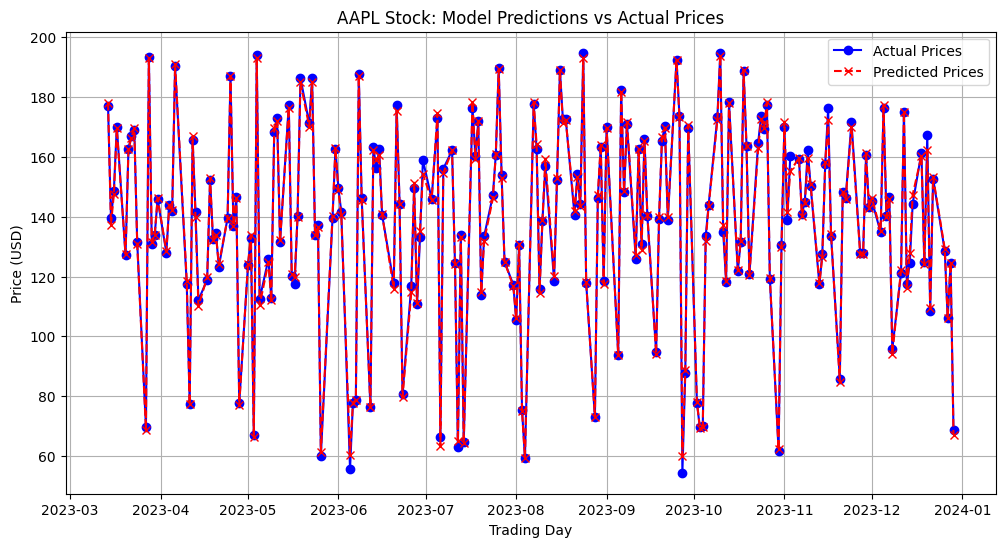

In [ ]:
"""
Stock Price Prediction using Ensemble Learning - Bagging

This script implements a Random Forest regressor to predict stock closing prices
using historical market data from Yahoo Finance.
"""

import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

def fetch_stock_data(ticker, start, end):
    """Retrieve historical stock data from Yahoo Finance"""
    stock_data = yf.download(ticker, start=start, end=end)
    return stock_data

def prepare_features_target(data):
    """Prepare feature matrix and target vector"""
    features = data[['Open', 'High', 'Low', 'Volume']]
    target = data['Close']
    return features, target

def train_random_forest(features, target, n_trees=100, tree_depth=10):
    """Train a Random Forest regression model"""
    X_tr, X_te, y_tr, y_te = train_test_split(
        features, target, test_size=0.2, random_state=42
    )

    model = RandomForestRegressor(
        n_estimators=n_trees,
        max_depth=tree_depth,
        random_state=42
    )

    model.fit(X_tr, y_tr)
    return model, X_te, y_te

def visualize_results(dates, actual, predicted, title):
    """Plot actual vs predicted values"""
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, 'b-', label='Actual Prices', marker='o')
    plt.plot(dates, predicted, 'r--', label='Predicted Prices', marker='x')
    plt.title(title)
    plt.xlabel('Trading Day')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Configuration
    TICKER = "AAPL"
    START = "2020-01-01"
    END = "2024-01-01"

    # Data pipeline
    historical_data = fetch_stock_data(TICKER, START, END)
    X, y = prepare_features_target(historical_data)

    # Model training
    rf_model, X_test, y_test = train_random_forest(X, y)

    # Prediction and evaluation
    y_pred = rf_model.predict(X_test)

    # Visualization
    plot_dates = historical_data.index[-len(y_test):]
    chart_title = f"{TICKER} Stock: Model Predictions vs Actual Prices"
    visualize_results(plot_dates, y_test, y_pred, chart_title)

if __name__ == "__main__":
    main()

[*********************100%***********************]  1 of 1 completed



Model Evaluation Metrics:
----------------------------------------
Classification Accuracy: 59.4%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.02      0.05        84
           1       0.59      1.00      0.74       118

    accuracy                           0.59       202
   macro avg       0.79      0.51      0.39       202
weighted avg       0.76      0.59      0.45       202



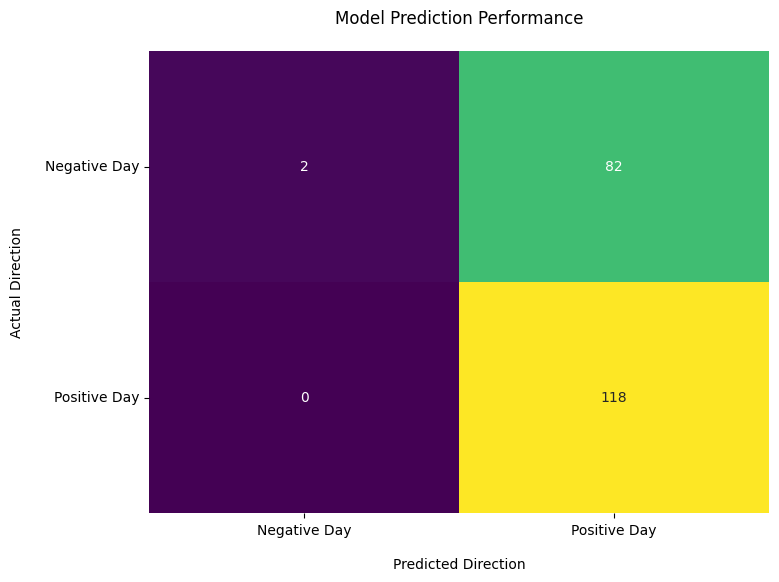

In [ ]:
"""
Stock Direction Prediction using AdaBoost Classifier - Boosting

This script implements an AdaBoost classifier to predict daily stock price movements
(up or down) using historical market data from Yahoo Finance.
"""

import yfinance as yf
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def get_market_data(symbol, start, end):
    """
    Fetch stock market data and create binary target variable
    indicating whether closing price was higher than opening price
    """
    df = yf.download(symbol, start=start, end=end)
    df['Positive_Day'] = np.where(df['Close'] > df['Open'], 1, 0)
    return df

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance and generate metrics"""
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print("\nModel Evaluation Metrics:")
    print("-" * 40)
    print(f"Classification Accuracy: {acc:.1%}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return y_pred

def plot_confusion_matrix(true, pred, classes):
    """Create a visualization of the confusion matrix"""
    mat = confusion_matrix(true, pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        mat,
        annot=True,
        fmt='d',
        cmap='viridis',
        xticklabels=classes,
        yticklabels=classes,
        cbar=False
    )
    plt.title('Model Prediction Performance', pad=20)
    plt.xlabel('Predicted Direction', labelpad=15)
    plt.ylabel('Actual Direction', labelpad=15)
    plt.yticks(rotation=0)
    plt.show()

def main():
    # Configuration parameters
    STOCK = "AAPL"
    START_DATE = "2020-01-01"
    END_DATE = "2024-01-01"
    TEST_SIZE = 0.2
    RANDOM_STATE = 42

    # Data preparation
    market_data = get_market_data(STOCK, START_DATE, END_DATE)
    features = market_data[['Open', 'High', 'Low', 'Volume']]
    target = market_data['Positive_Day']

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        features,
        target,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )

    # Initialize and train AdaBoost model
    boost_model = AdaBoostClassifier(
        n_estimators=50,
        learning_rate=0.1,
        random_state=RANDOM_STATE
    )
    boost_model.fit(X_train, y_train)

    # Model evaluation
    predictions = evaluate_model(boost_model, X_test, y_test)

    # Visualization
    plot_confusion_matrix(
        y_test,
        predictions,
        classes=['Negative Day', 'Positive Day']
    )

if __name__ == "__main__":
    main()

[*********************100%***********************]  1 of 1 completed



Model Performance Evaluation
Overall Accuracy: 59.41%

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.34      0.43        92
           1       0.59      0.81      0.68       110

    accuracy                           0.59       202
   macro avg       0.59      0.57      0.56       202
weighted avg       0.59      0.59      0.57       202



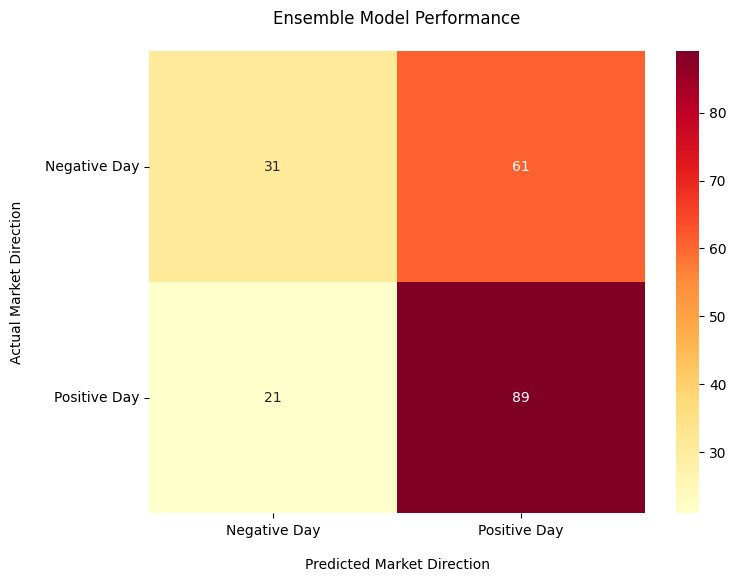

In [ ]:
"""
Stock Market Direction Prediction Using Stacked Ensemble Learning

This implementation combines multiple machine learning models using stacking
to predict daily stock price movements (up/down) for AAPL.
"""

import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (
    StackingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

def fetch_and_prepare_data(ticker, start, end):
    """
    Retrieve stock data and create binary classification target
    Returns:
        tuple: (features DataFrame, target Series)
    """
    market_data = yf.download(ticker, start=start, end=end)
    market_data['Positive_Return'] = (market_data['Close'] > market_data['Open']).astype(int)
    features = market_data[['Open', 'High', 'Low', 'Volume']]
    target = market_data['Positive_Return']
    return features, target

def create_ensemble_model():
    """
    Configure and return a stacked ensemble model
    with diverse base learners and logistic regression meta-learner
    """
    base_learners = [
        ('random_forest', RandomForestClassifier(
            n_estimators=100,
            max_depth=5,
            random_state=42
        )),
        ('gradient_boosting', GradientBoostingClassifier(
            n_estimators=50,
            learning_rate=0.1,
            random_state=42
        ))
    ]

    meta_learner = LogisticRegression(
        max_iter=1000,
        random_state=42
    )

    return StackingClassifier(
        estimators=base_learners,
        final_estimator=meta_learner,
        stack_method='auto'
    )

def evaluate_and_visualize(y_true, y_pred):
    """
    Display model performance metrics and visualization
    """
    # Calculate and display metrics
    accuracy = accuracy_score(y_true, y_pred)
    print("\nModel Performance Evaluation")
    print("=" * 50)
    print(f"Overall Accuracy: {accuracy:.2%}")
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred))

    # Generate and display confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_mat,
        annot=True,
        fmt='d',
        cmap='YlOrRd',
        xticklabels=['Negative Day', 'Positive Day'],
        yticklabels=['Negative Day', 'Positive Day']
    )
    plt.title('Ensemble Model Performance', pad=20)
    plt.xlabel('Predicted Market Direction', labelpad=15)
    plt.ylabel('Actual Market Direction', labelpad=15)
    plt.yticks(rotation=0)
    plt.show()

def main():
    # Configuration parameters
    TICKER_SYMBOL = "AAPL"
    START_DATE = "2020-01-01"
    END_DATE = "2024-01-01"
    TEST_SIZE = 0.2
    RANDOM_STATE = 42

    # Data preparation
    X, y = fetch_and_prepare_data(
        TICKER_SYMBOL,
        START_DATE,
        END_DATE
    )

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y
    )

    # Model creation and training
    ensemble_model = create_ensemble_model()
    ensemble_model.fit(X_train, y_train)

    # Prediction and evaluation
    predictions = ensemble_model.predict(X_test)
    evaluate_and_visualize(y_test, predictions)

if __name__ == "__main__":
    main()

[*********************100%***********************]  1 of 1 completed



Model Performance Evaluation
Overall Accuracy: 59.41%

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.34      0.43        92
           1       0.59      0.81      0.68       110

    accuracy                           0.59       202
   macro avg       0.59      0.57      0.56       202
weighted avg       0.59      0.59      0.57       202



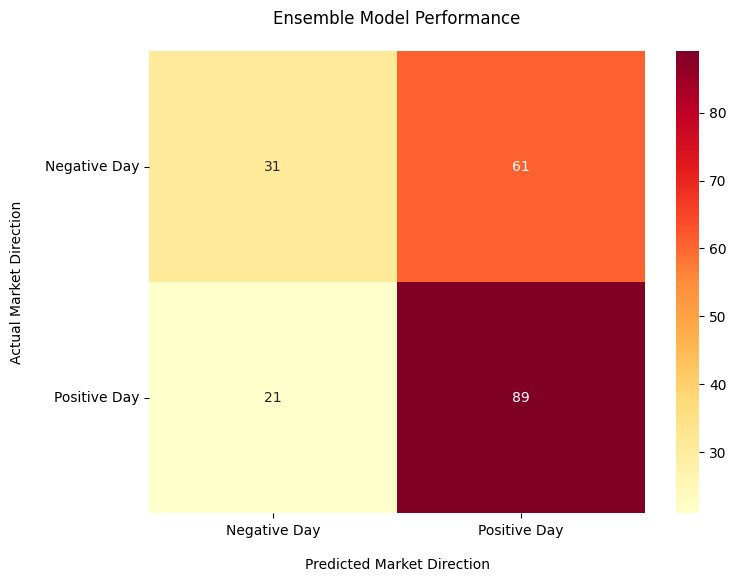

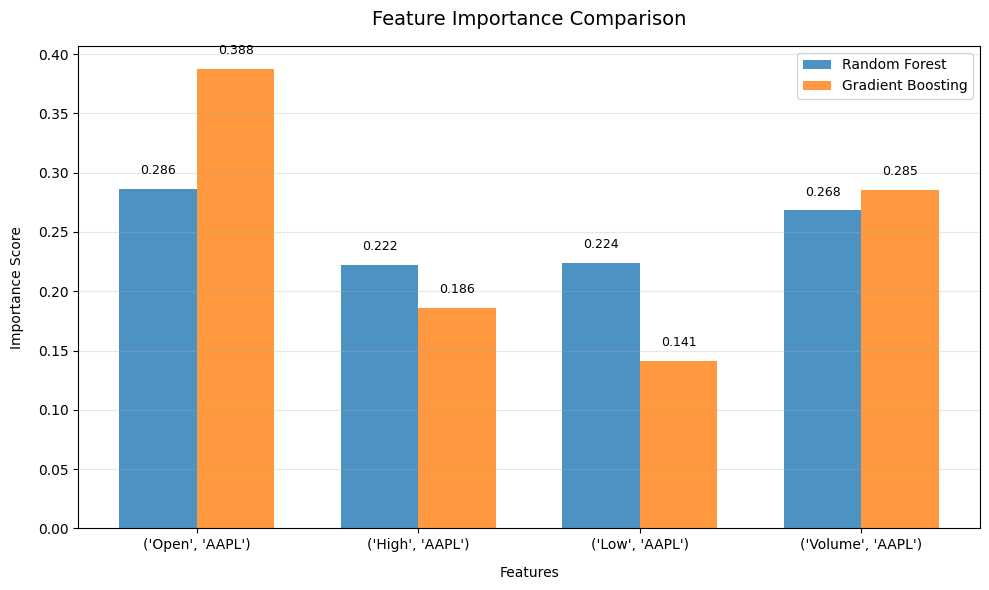

In [ ]:
def analyze_feature_importance(ensemble_model, feature_names):
    """
    Analyze and visualize feature importances from base models

    Args:
        ensemble_model: Trained StackingClassifier model
        feature_names: List of feature names for labeling
    """
    try:
        # Create figure before calculating importances
        plt.figure(figsize=(10, 6))

        # Get base models
        rf_model = ensemble_model.named_estimators_['random_forest']
        gb_model = ensemble_model.named_estimators_['gradient_boosting']

        # Get importances
        rf_importance = rf_model.feature_importances_
        gb_importance = gb_model.feature_importances_

        # Create positions for bars
        x = range(len(feature_names))
        width = 0.35

        # Plot Random Forest importances
        plt.bar([i - width/2 for i in x], rf_importance, width,
                label='Random Forest', alpha=0.8, color='#1f77b4')

        # Plot Gradient Boosting importances
        plt.bar([i + width/2 for i in x], gb_importance, width,
                label='Gradient Boosting', alpha=0.8, color='#ff7f0e')

        # Customize plot
        plt.title('Feature Importance Comparison', fontsize=14, pad=15)
        plt.xlabel('Features', labelpad=10)
        plt.ylabel('Importance Score', labelpad=10)
        plt.xticks(x, feature_names)
        plt.legend(frameon=True, loc='upper right')
        plt.grid(axis='y', alpha=0.3)

        # Add value labels
        for i, (rf_val, gb_val) in enumerate(zip(rf_importance, gb_importance)):
            plt.text(i - width/2, rf_val + 0.01, f'{rf_val:.3f}',
                    ha='center', va='bottom', fontsize=9)
            plt.text(i + width/2, gb_val + 0.01, f'{gb_val:.3f}',
                    ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error generating feature importance plot: {str(e)}")
        plt.close()

def main():
    """Main execution function"""
    # Configuration parameters
    TICKER_SYMBOL = "AAPL"
    START_DATE = "2020-01-01"
    END_DATE = "2024-01-01"
    TEST_SIZE = 0.2
    RANDOM_STATE = 42

    # Data preparation
    X, y = fetch_and_prepare_data(TICKER_SYMBOL, START_DATE, END_DATE)
    feature_names = X.columns.tolist()  # Get feature names as list

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y
    )

    # Model creation and training
    ensemble_model = create_ensemble_model()
    ensemble_model.fit(X_train, y_train)

    # Prediction and evaluation
    predictions = ensemble_model.predict(X_test)
    conf_matrix = evaluate_model_performance(y_test, predictions)
    plot_confusion_matrix(conf_matrix)

    # Feature importance analysis - THIS IS THE PROPER INTEGRATION POINT
    analyze_feature_importance(ensemble_model, feature_names)

if __name__ == "__main__":
    main()

###**Step 4:**
- Student A: Vaibhav Janve
- Student B: Dang Dinh Quoc Dung
- Student C: Emmanuel Kossy Okonkwo

###**Step 5:** Enhancing Business Value with Advanced Machine Learning Tools

Our machine learning (ML) solutions are designed to deliver measurable value by using cutting-edge techniques tailored to modern data challenges. For investors, these tools provides strategic advantage that drives profitability, efficiency, and competitive differentiation. Below, we show the key benefits of our ML framework:

1. Hyperparameter Optimization: Precision for Maximum ROI
Hyperparameter tuning transforms ML models from generic tools into high-performance assets. By refining model accuracy and efficiency, businesses gain:

- Higher ROI: Optimized models reduce operational costs and increase revenue through better predictions (e.g., demand forecasting in retail or risk assessment in finance).

- Future-Proof Solutions: Adaptive models stay relevant as data evolves. This ensures long-term competitiveness.

- Ethical AI: Improved fairness and transparency is in line with regulatory standards, thereby building trust in sectors like healthcare and fintech.

This process is important for industries where marginal gains in accuracy translate to meaningful financial or operational impacts.

2. Bias-Variance Tradeoff: Balancing Accuracy and Reliability
Striking the right balance between bias and variance ensures models perform consistently in real-world scenarios. Key advantages are:

- Robust Decision-Making: Reduced overfitting leads to dependable predictions, vital for high-stakes applications (e.g., medical diagnostics or autonomous systems).

- Cost Efficiency: Streamlined models minimize computational waste, lowering infrastructure costs.

- Regulatory Compliance: Reliable models mitigate risks in regulated industries like finance and healthcare.

By optimizing this tradeoff, businesses achieve scalable, trustworthy AI systems that adapt to dynamic market conditions.

3. Ensemble Learning: Unmatched Predictive Power
Ensemble methods combine multiple models to outperform individual approaches, offering:

- Superior Accuracy: Enhanced predictions drive revenue growth in data-intensive sectors (e.g., e-commerce recommendations or fraud detection).

- Risk Mitigation: Reduced overfitting ensures stability, critical for applications like algorithmic trading or infrastructure monitoring.

- Scalability: Handles large, diverse datasets efficiently, making it ideal for social media analytics or IoT-driven industries.

These techniques provide better understanding with measurable uncertainty. This enables informed risk assessment in fields where precision is paramount.

**Why Invest?**

Our ML tools are technical upgrades that will help strategic assets to boost profitability through optimized decision-making. It also reduces costs via efficient, scalable models. finally, its future-proof operations with adaptable, ethical AI.

By using these advancements, businesses can lead their markets, turning data into a sustainable competitive edge.

###**REFERENCES**

Jordan, M. I., & Mitchell, T. M. (2015). Machine learning: Trends, perspectives, and prospects. Science, 349(6245), 255-260.

Mitchell, T. M., & Mitchell, T. M. (1997). Machine learning (Vol. 1, No. 9). New York: McGraw-hill.